<a href="https://colab.research.google.com/github/Tanuj2552/Home-Automation-using-EEG/blob/main/Classification_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

shape of EEG:  (59, 190473)
sample rate:  100
Number of channels:  59
Channel names:  ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of Events:  1
Event codes:  [-1  1]
Class labels:  ['left', 'right']
Number of classes:  2
Shape of trials[cl1]:  (59, 200, 100)
Shape of trials[cl2]:  (59, 200, 100)


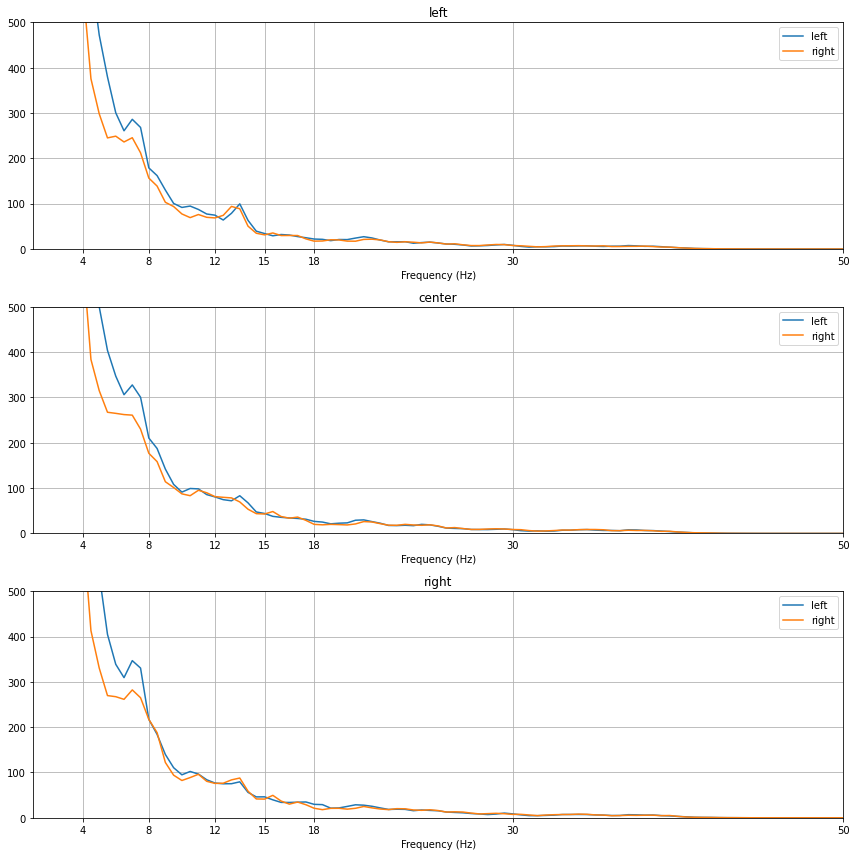

In [ ]:
import scipy.io 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import gdown
 
m = scipy.io.loadmat(r'/content/drive/MyDrive/BCICIV_1_mat/BCICIV_calib_ds1d.mat',struct_as_record = True)
 
sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape
 
channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]

labels = np.zeros((1,nsamples),int)
labels[0, event_onsets] = event_codes
 
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
 
nclasses = len(cl_lab)
nevents = len(event_onsets)
 
print('shape of EEG: ',EEG.shape)
print('sample rate: ',sample_rate)
print('Number of channels: ',nchannels)
print('Channel names: ',channel_names)
print('Number of Events: ',len(event_onsets))
print('Event codes: ',np.unique(event_codes))
print('Class labels: ',cl_lab)
print('Number of classes: ',nclasses)
 
 
 
trials = {}
 
win = np.arange(int(0.5*sample_rate),int(2.5*sample_rate))
 
nsamples = len(win)
 
for cl, code in zip(cl_lab, np.unique(event_codes)):
 
    cl_onsets = event_onsets[event_codes == code]
 
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
 
    for i,onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+int(onset*0.1)]
 
print('Shape of trials[cl1]: ',trials[cl1].shape)
print('Shape of trials[cl2]: ',trials[cl2].shape)
 
def psd(trials):
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))
 
    for trial in range(ntrials):
        for ch in range(nchannels):
 
            (PSD,freqs) = mlab.psd(trials[ch,:,trial],NFFT=int(nsamples),Fs=sample_rate)
            trials_PSD[ch,:,trial] = PSD.ravel()
 
    return trials_PSD,freqs
 
psd_r, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}
 
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab = None, maxy = None):
 
    plt.figure(figsize = (12,12))
    nchans = len(chan_ind)
 
    ncols = np.ceil(nchans/3)
    nrows = min(3,nchans)
 
    for i,ch in enumerate(chan_ind):
        plt.subplot(nrows,ncols,i+1)
 
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:],axis = 1), label = cl)
 
        plt.xlim(1,30)
 
        if(maxy != None):
            plt.ylim(0,maxy)
        else:
            plt.ylim(1,1200)
        
        plt.grid()
 
        plt.xlabel('Frequency (Hz)')
 
        if(chan_lab == None):
            plt.title(f'Channel {ch+1}')
        else:
            plt.title(chan_lab[i])

        plt.xticks([4,8,12,15,18,30,50], [4,8,12,15,18,30,50])
 
        plt.legend()
 
    plt.tight_layout()
 
plot_psd(trials_PSD,freqs, [channel_names.index(ch) for ch in ['C3','Cz','C4']], chan_lab = ['left','center','right'],maxy = 500)


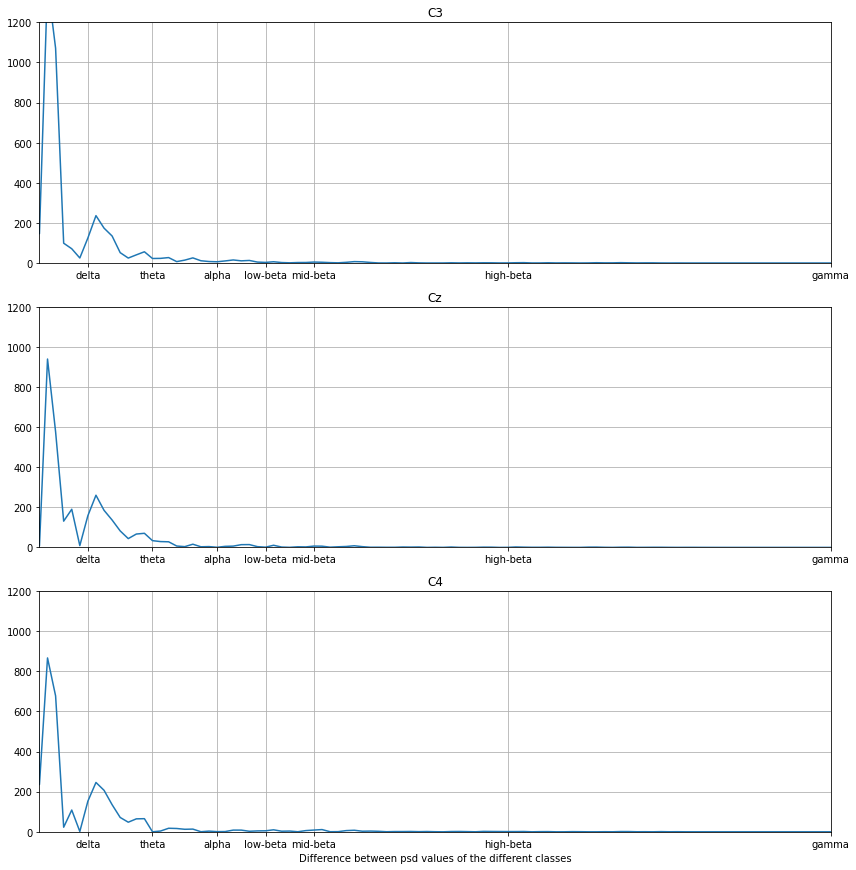

In [ ]:
def plot_diff_freqs(trials_PSD, useful_chan, max_x = None, max_y = None):
    #useful_chan = ['C3', 'Cz', 'C4']
 
    fig = plt.figure(figsize = (12,12))
    nchans = len(useful_chan)
    ncols = np.ceil(nchans/3)
    nrows = min(3,nchans)
 
    
    for i in range(len(useful_chan)):
        plt.subplot(nrows,ncols,i+1)
        
        chan = useful_chan[i] 
        plt.plot(freqs, abs(np.mean(trials_PSD['left'][channel_names.index(chan),:,:],axis = 1) - np.mean(trials_PSD['right'][channel_names.index(chan),:,:],axis = 1)))
        if(max_x):
            plt.xlim(1,max_x)
        else:
            plt.xlim(1,30)
        if(max_y):
            plt.ylim(1,max_y)
        else:
            plt.ylim(0,1200)
        plt.grid()
        plt.title(str(useful_chan[i]))
        
        plt.xticks([4,8,12,15,18,30,50], ['delta', 'theta', 'alpha', 'low-beta','mid-beta','high-beta', 'gamma'])
 
    plt.tight_layout()
    plt.xlabel("Difference between psd values of the different classes")
 
plot_diff_freqs(trials_PSD,['C3', 'Cz', 'C4'])
# https://nhahealth.com/brainwaves-the-language/#:~:text=The%20raw%20EEG%20has%20usually,(less%20than%204%20Hz).
#From various resources from the net, we conclude that mostly alpha and low beta waves (8-15 hz) contribute to the mind/body coordination, integration & associated tasks

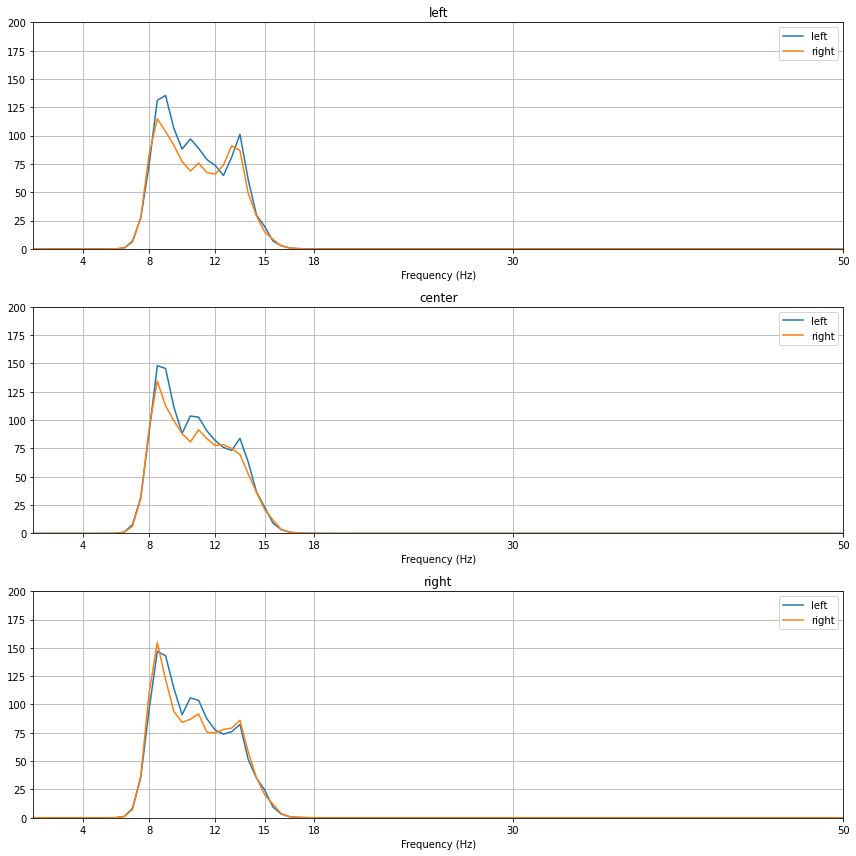

In [ ]:
from scipy import signal
def bpf(trials, bpf_range, N):
    a, b = scipy.signal.iirfilter(6, [float(float(x)/50.0) for x in  bpf_range])
    
    trial_keys = list(trials.keys())
    ntrials = trials[trial_keys[0]].shape[2]
    trials_bpf = {}
    for j in trial_keys:
        trials_bpf[j] = np.zeros((nchannels, nsamples, ntrials))
        for i in range(ntrials):
            trials_bpf[j][:,:,i] = signal.lfilter(a, b, trials[j][:,:,i], axis=1)
    
    return trials_bpf
    
trials_bpf = bpf(trials, [8,15], 6)

psd_r, freqs = psd(trials_bpf[cl1])
psd_f, freqs = psd(trials_bpf[cl2])

trials_psd_bpf = {cl1:psd_r, cl2:psd_f}



plot_psd(trials_psd_bpf,freqs, [channel_names.index(ch) for ch in ['C3','Cz','C4']], chan_lab = ['left','center','right'],maxy = 200)

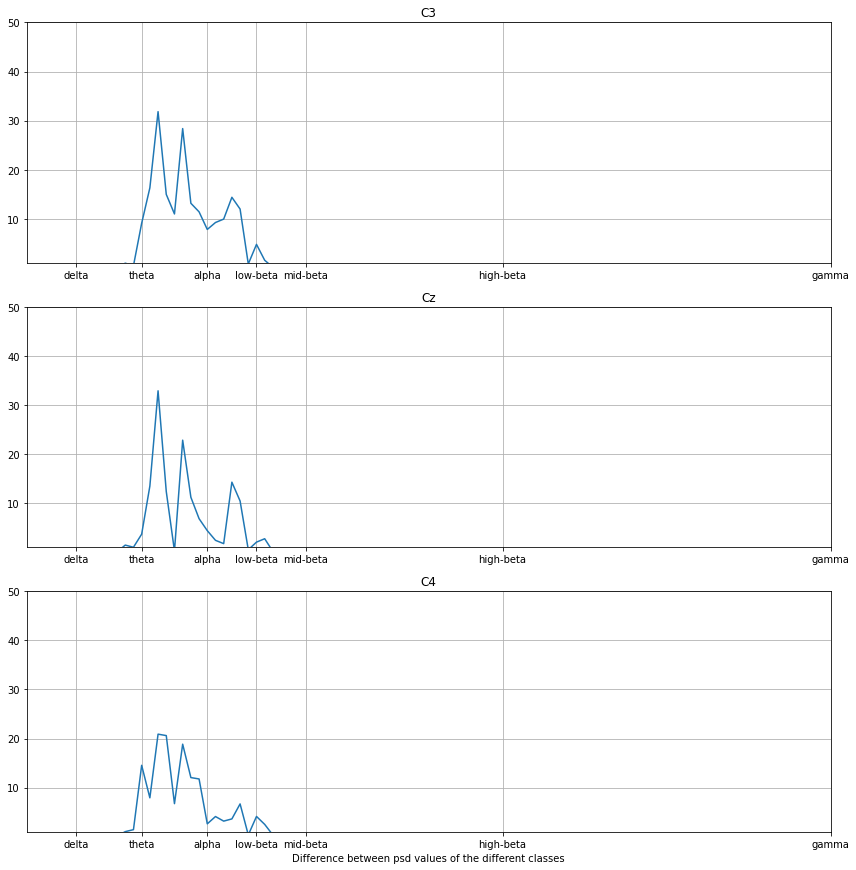

In [ ]:
plot_diff_freqs(trials_psd_bpf, ['C3', 'Cz', 'C4'], max_y = 50)

In [ ]:
trails_logvar_cl1 = np.log(np.var(trials_psd_bpf[cl1], axis = 1))
trails_logvar_cl2 = np.log(np.var(trials_psd_bpf[cl2], axis = 1))


In [ ]:
trails_logvar_feat = {cl1: trails_logvar_cl1, cl2: trails_logvar_cl2}

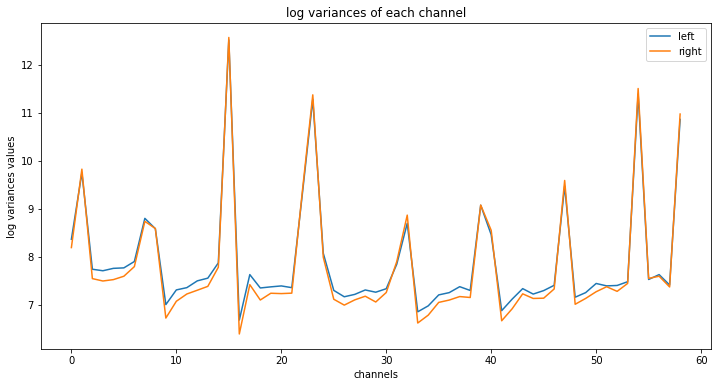

In [ ]:
def plot_logvar(trails):
    plt.figure(figsize = (12,6))

    x_data = list(range(nchannels))

    y1 = np.mean(trails[cl1], axis = 1)
    y2 = np.mean(trails[cl2], axis = 1)

    plt.plot(x_data, y1)
    plt.plot(x_data, y2)

    plt.legend(['left', 'right'])

    plt.xlabel('channels')
    plt.ylabel('log variances values')
    plt.title('log variances of each channel')

plot_logvar(trails_logvar_feat)


In [ ]:

from numpy import linalg

def cov(data):
    n = data.shape[2]
    covs = [ data[:,:,i].dot(data[:,:,i].T) / nsamples for i in range(n) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(data_1, data_2):
    cov_1 = cov(data_1)
    cov_2 = cov(data_2)
    P = whitening(cov_1 + cov_2)
    B, _, _ = linalg.svd( P.T.dot(cov_2).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, data):
    n = data.shape[2]
    data_csp = np.zeros((nchannels, nsamples, n))
    for i in range(n):
        data_csp[:,:,i] = W.T.dot(data[:,:,i])
    return data_csp


In [ ]:
W = csp(trials_bpf[cl1], trials_bpf[cl2])
trials_bpf_csp = {cl1: apply_mix(W, trials_bpf[cl1]),
              cl2: apply_mix(W, trials_bpf[cl2])}

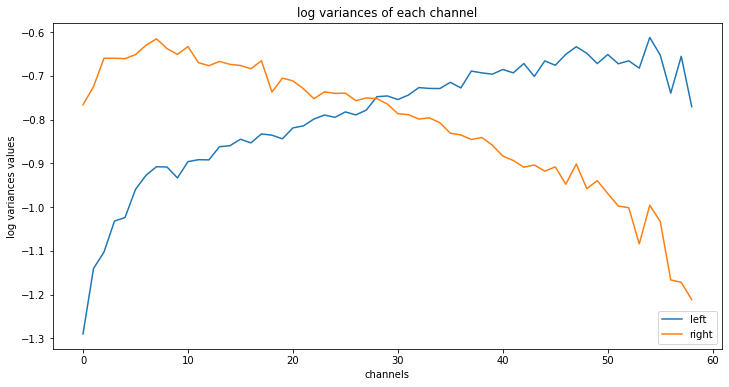

In [ ]:
trials_logvar_csp = {cl1: np.log(np.var(trials_bpf_csp[cl1],axis = 1)),
                 cl2: np.log(np.var(trials_bpf_csp[cl2], axis = 1))}
plot_logvar(trials_logvar_csp)

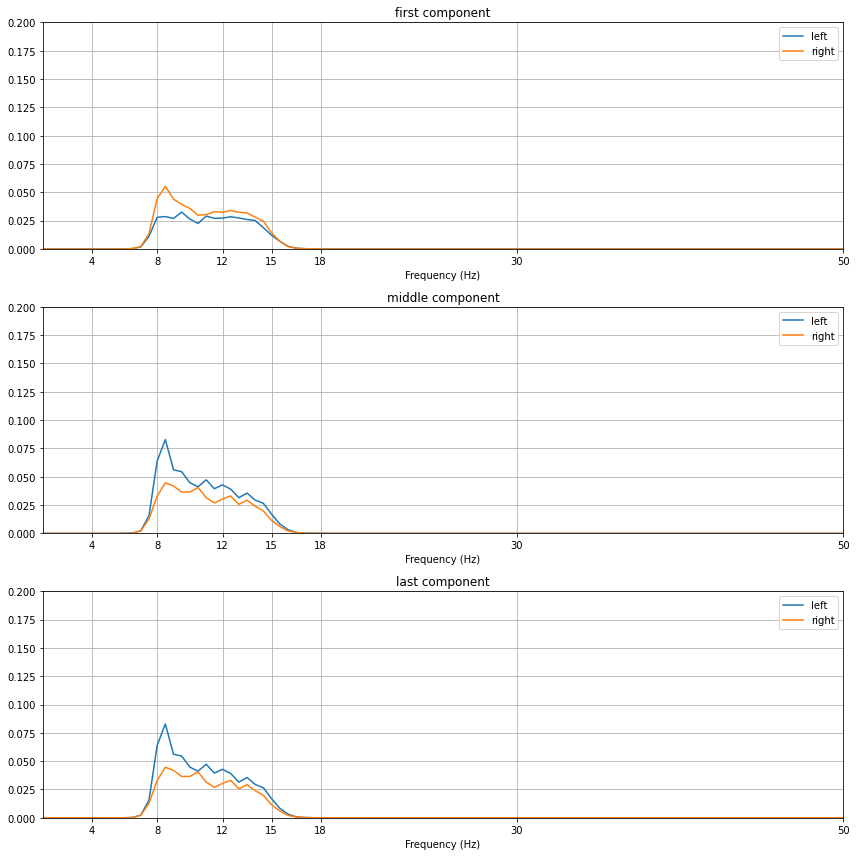

In [ ]:
psd_r, freqs = psd(trials_bpf_csp[cl1])
psd_f, freqs = psd(trials_bpf_csp[cl2])

trials_psd_bpf_csp = {cl1:psd_r, cl2:psd_f}

plot_psd(trials_psd_bpf_csp, freqs, [0,58,-1], chan_lab=['first component', 'middle component', 'last component'], maxy = 0.2)

In [ ]:
split_percentage = 0.75

ntrain_r = int(trials_bpf[cl1].shape[2] * split_percentage)
ntrain_f = int(trials_bpf[cl2].shape[2] * split_percentage)

train = {cl1: trials_bpf[cl1][:,:,:ntrain_r],
         cl2: trials_bpf[cl2][:,:,:ntrain_f]}

test = {cl1: trials_bpf[cl1][:,:,ntrain_r:],
        cl2: trials_bpf[cl2][:,:,ntrain_f:]}


W = csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

comp = np.array([0,-1,30,40,20])
comp = np.array([channel_names.index(ch) for ch in ['C3','Cz','C4']])
comp = np.array(list(range(59)))
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]


train[cl1] = np.log(np.var((train[cl1]), axis = 1))
train[cl2] = np.log(np.var((train[cl2]),axis = 1))
test[cl1] = np.log(np.var((test[cl2]),axis = 1))
test[cl2] = np.log(np.var((test[cl2]),axis = 1))



In [ ]:
df = pd.DataFrame()
df2 = pd.DataFrame()
Y1 = []
Y2 = []

for i in range(len(comp)):
    df[channel_names[comp[i]]] = np.append(train[cl1][i],test[cl1][i])
    df2[channel_names[comp[i]]] = np.append(train[cl2][i],test[cl2][i])
    

Y1 = [0]*len(df)
Y2 = [1]*len(df2)
Y_final = Y1 + Y2

df_final = pd.concat([df, df2])
df_total = df_final.copy()
df_total['Y'] = Y_final

print(df)
print(df2)
print(df_final)
df_total = df_total.sample(frac = 1)
print(df_total)

         AF3       AF4        F5  ...       PO2        O1        O2
0  -1.293883 -0.558199 -1.424345  ... -1.246159  0.463444  0.412153
1  -1.142830 -1.262179 -1.141020  ... -0.411696 -1.193933 -0.803508
2  -1.632907 -0.546396 -1.324356  ... -0.372195 -0.864807 -1.708206
3  -1.039638 -0.748650 -0.975612  ...  1.857521 -0.009875 -1.394664
4  -1.024207 -1.181740 -1.393440  ... -1.637738  0.865947 -1.100723
..       ...       ...       ...  ...       ...       ...       ...
95 -0.435012 -0.691531 -1.156020  ... -0.807005 -0.820161 -1.426626
96  0.114394 -0.485024 -0.977653  ... -0.428150 -1.513420 -0.785331
97 -0.493389 -0.577490 -0.151336  ... -0.747821 -1.258630 -0.279989
98 -0.126374 -1.404032 -0.315866  ... -1.951425 -1.768477 -1.159696
99 -1.277867 -1.357191 -0.219122  ... -0.856081 -1.728683 -0.576869

[100 rows x 59 columns]
         AF3       AF4        F5  ...       PO2        O1        O2
0   0.040202 -0.935722 -0.320776  ... -0.608096 -0.884127 -0.951995
1  -0.497102 -0.579643 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
def my_confusion_matrix(predicted, Y_test):
    l = len(predicted)
    check = [predicted[i] == Y_test[i] for i in range(l)]

    conf = np.array([
   [ [predicted[i]==Y_test[i]==1 for i in range(l)].count(1), Y_test.count(1) - [predicted[i]==Y_test[i]==1 for i in range(l)].count(1) ],
    [ Y_test.count(0) -[predicted[i]==Y_test[i]==0 for i in range(l)].count(1), [predicted[i]==Y_test[i]==0 for i in range(l)].count(1) ],
])
    print("The Confusion Matrix is given as: ")
    print(conf)
    acc = [predicted[i] == Y_test[i] for i in range(len(predicted))].count(1) / len(predicted)
    print("the accuracy is: ",acc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_final, Y_final, test_size=0.25, random_state=400)
classifier = SVC(kernel = 'linear', C=0.9).fit(X_train, y_train)

In [ ]:
classifier.score(X_test, y_test)

0.76

In [ ]:
predicted = classifier.predict(X_test)
my_confusion_matrix(predicted, y_test)

The Confusion Matrix is given as: 
[[19  8]
 [ 4 19]]
the accuracy is:  0.76


In [ ]:
scores = cross_val_score(classifier, X_test, y_test, cv=10)
print(scores)

[0.8 0.6 0.4 0.8 0.8 0.6 1.  0.6 0.8 1. ]


In [ ]:
print('')
print(*predicted)
print(*y_test)


0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1
0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_values = {'C':[0.5,0.4,0.3,0.6,0.7,0.8,0.9,1,5], 'kernel':['linear', 'rbf', 'sigmoid'] }
grid_classifier = GridSearchCV(classifier, param_grid = grid_values, scoring = 'accuracy')
grid_classifier.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=0.9, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 0.4, 0.3, 0.6, 0.7, 0.8, 0.9, 1, 5],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
print(grid_classifier.best_score_)
print(grid_classifier.best_params_)

0.74
{'C': 0.6, 'kernel': 'rbf'}


In [ ]:
trail_classifier = SVC(kernel = 'rbf', C=0.6)
trail_classifier.fit(X_train, y_train)
trail_predict = trail_classifier.predict(X_test)
my_confusion_matrix(trail_predict, y_test)

The Confusion Matrix is given as: 
[[19  8]
 [ 1 22]]
the accuracy is:  0.82


In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, trail_predict)
print(matrix)

[[22  1]
 [ 8 19]]


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_predict = lda.predict(X_test)

In [ ]:
my_confusion_matrix(lda_predict, y_test)

The Confusion Matrix is given as: 
[[18  9]
 [ 3 20]]
the accuracy is:  0.76


In [ ]:
grid_values_lda = {'solver':['svd','lsqr','eigen'] }
grid_classifier_lda = GridSearchCV(lda, param_grid = grid_values_lda, scoring = 'accuracy')
grid_classifier_lda.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

1

1

1

1

1

1

1

In [ ]:
def train_lda(class1, class2):
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

def apply_lda(test, W, b):
  
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):
        result = W.dot(test[:,i]) - b
        
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [ ]:
W,b = train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

W: [ 1.65173372e+00  3.61228171e-01  2.91813241e+00  1.32181255e+00
  6.06405538e-01  1.52443245e+00  1.77357992e+00  2.14935232e+00
  3.29676559e+00  1.21850906e+00  1.59221518e+00 -8.03447767e-01
  1.81487276e+00 -1.28845281e+00  2.71650645e+00 -6.51043878e+00
 -1.75427677e+00  1.55878416e+00  2.25025466e+00  2.98209770e+00
  2.32996392e-01 -3.57841322e+00  2.24826618e+00 -9.99415884e-01
  4.36257021e-01 -4.06921976e-01 -3.11405971e-02  6.95871914e-01
  3.44129965e+00  5.87763684e-01 -5.80608195e-01 -2.12823171e+00
 -1.46523496e+00  3.05647890e-01  3.99865565e+00 -2.15121495e+00
 -2.42696970e+00 -3.20906117e+00  1.34976350e+00  3.75128892e+00
 -1.41013103e+00 -1.49269917e+00  2.11596405e+00  2.45919453e-01
 -1.45365540e-01  5.12406184e-03 -2.78974523e+00 -2.52164493e+00
 -4.49474168e-01  3.01661908e+00 -2.05040739e+00  7.49532263e-01
 -1.55475951e+00 -4.12382511e+00 -1.64720148e+00 -2.84041271e+00
 -2.99009809e+00 -3.11970337e+00 -1.69832209e+00]
b: 3.1163572725343887


(-2.2, 1.0)

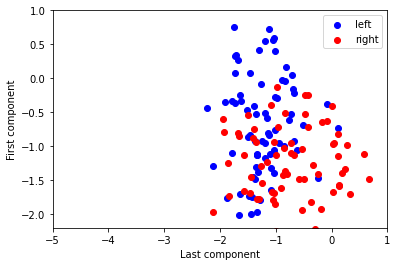

In [ ]:
def plot_scatter(left, foot):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b')
    plt.scatter(foot[0,:], foot[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

plot_scatter(train[cl1], train[cl2])

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

In [ ]:
conf = np.array([
    [(apply_lda(test[cl1], W, b) == 1).sum(), (apply_lda(test[cl2], W, b) == 1).sum()],
    [(apply_lda(test[cl1], W, b) == 2).sum(), (apply_lda(test[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[ 9  9]
 [16 16]]

Accuracy: 0.500
